# Weight Initialization
В этом ноутбуке вы узнаете, как найти хорошие начальные веса для нейронной сети.
Инициализация весов происходит один раз, когда модель создана, до обучения.
Имея хорошие начальные веса, можно расположить нейронную сеть близко к оптимальному решению.
Это позволяет нейронной сети быстрее сойтись к наилучшему решению.


## Initial Weights and Observing Training Loss

Чтобы увидеть, как работают различные веса, мы протестируем один и тот же набор данных и нейронную сеть. Таким образом, мы знаем, что любые изменения в поведении модели происходят из-за весов, а не из-за каких-либо изменений данных или структуры модели.

### Dataset and Model

Для изучения различных инициализаций мы обучим MLP классифицировать изображения из набора данных [Fashion-MNIST] (https://github.com/zalandoresearch/fashion-mnist). Набор данных FashionMNIST содержит изображения типов одежды; ' classes = ['футболка / топ', 'брюки', 'пуловер', 'платье', 'пальто', 'сандалии', 'рубашка', 'кроссовки', 'сумка',`ботильоны']'. Изображения нормализуются таким образом, чтобы их пиксельные значения находились в диапазоне [0.0 - 1.0).  Запустите ячейку ниже, чтобы загрузить данные.



### Import Libraries and Load [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

In [33]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize Some Training Data

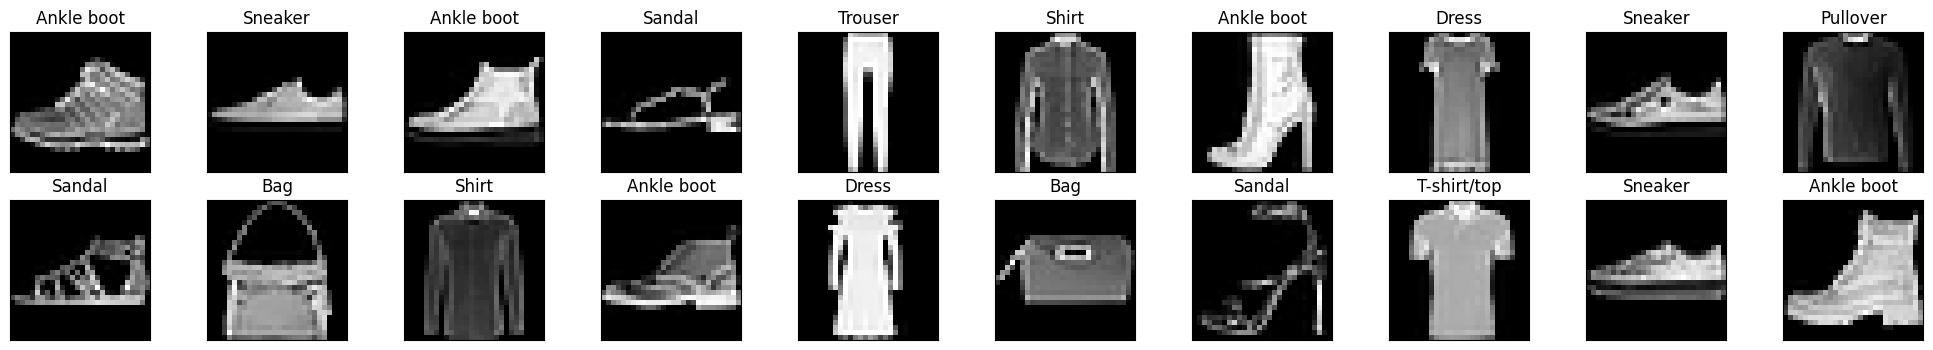

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

## Архитектура модели

Мы создадим MLP (multilayer perceptron), который будем использовать для классификации данных, со следующими характеристиками:


* 3 линейных слоя с размерами 256 и 128;

* MLP принимает в качестве входных данных выпрямленное изображение (вектор длины 784) и выдает оценку принадлежности объекта к каждому из 10 классов.
---
Мы проверим влияние различных инициализаций на эту 3-слойную нейронную сеть, обученную с активациями ReLU и оптимизатором Adam.  

Полученные выводы применимы и к другим нейронным сетям, включая различные активации и оптимизаторы.

---

### All Zeros or Ones
Следуя принципам бритвы Оккама ([Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor)), вы могли бы естестевенно подумать, что достаточно проиницализировать все веса нулем или единицей.

При одинаковом весе все нейроны в каждом слое выдают одинаковый результат.  Это затрудняет обучение, так как непонятно, какие именно веса в какую сторону нужно менять.

Давайте сравним функции потерь для двух моделей, проинициализированных (1) нулями и (2) единицами.

Ниже мы используем Pytorch's [nn. init](https://pytorch.org/docs/stable/nn.html#torch-nn-init), чтобы проинициализировать веса каждого линейного слоя константной. Библиотека init предоставляет ряд функций инициализации, которые дают возможность инициализировать веса каждого слоя в соответствии с его типом.
Для линейного слоя веса инициализируются следующим образом:

>```
if isinstance(m, nn.Linear):
    nn.init.constant_(m.weight, constant_weight)
    nn.init.constant_(m.bias, 0)
```

где `constant_weight` - значение константы (в нашем случае 0 или 1).

**Задание**: определите модель c описанной выше архитуктурой

In [35]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self, hidden_1=256, hidden_2=128, constant_weight=None):
        super(Net, self).__init__()
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(784, hidden_1)
        # linear layer (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (hidden_2 -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(p=0.2)

        # initialize the weights to a specified, constant value
        if(constant_weight is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.constant_(m.weight, constant_weight)
                    nn.init.constant_(m.bias, 0)


    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

### Сравнение поведения модели

Ниже мы используем функцию `.compare_init_weights`, чтобы сравнить функции потерь на обучении и тесте для двух моделей: `model_0` и `model_1`.  Эта функция принимает список моделей (каждая с различными начальными весами), название создаваемого графика, а также загрузчики обучающих и тестовых наборов данных. Для каждой заданной модели эта функцию построит график лосса га обучения для первых 100 батчей и выведет точность валидации после 2 эпох обучения.

*Примечание: Если вы использовали батчи меньшего размера, вы можете увеличить количество эпох здесь, чтобы лучше сравнить, как ведут себя модели после просмотра нескольких сотен изображений.*


**Задание**: Допишите обучение модели и запустите ячейки ниже, чтобы увидеть разницу между инициализациями всеми нулями и всеми единицами.

In [36]:
# initialize two NN's with 0 and 1 constant weights
model_0 = Net(constant_weight=0)
model_1 = Net(constant_weight=1)

In [37]:
import torch
import torch.nn as nn

def _get_loss_acc(model, train_loader, valid_loader):
    """
    Get losses and validation accuracy of example neural network
    """
    n_epochs = 2
    learning_rate = 0.001

    # Training loss
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Measurements used for graphing loss
    loss_batch = []

    for epoch in range(1, n_epochs+1):
        # initialize var to monitor training loss
        train_loss = 0.0

        # Training loop
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record average batch loss
            train_loss += loss.item()

        # Calculate average loss for the epoch
        avg_train_loss = train_loss / len(train_loader)
        loss_batch.append(avg_train_loss)

        print(f'Epoch {epoch}, Training Loss: {avg_train_loss:.4f}')

    # after training for 2 epochs, check validation accuracy
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for validation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # get the predicted class from the maximum class score
            _, predicted = torch.max(output.data, 1)

            # count up total number of correct labels
            # for which the predicted and true labels are equal
            total += target.size(0)
            correct += (predicted == target).sum()

    # calculate the accuracy
    # to convert `correct` from a Tensor into a scalar, use .item()
    valid_acc = correct.item() / total

    # return model stats
    return loss_batch, valid_acc

In [38]:

def compare_init_weights(
        model_list,
        plot_title,
        train_loader,
        valid_loader,
        plot_n_batches=100):
    """
    Plot loss and print stats of weights using an example neural network
    """
    colors = ['r', 'b', 'g', 'c', 'y', 'k']
    label_accs = []
    label_loss = []

    assert len(model_list) <= len(colors), 'Too many initial weights to plot'

    for i, (model, label) in enumerate(model_list):
        torch.save(model.state_dict(), f"{label}.pt")

        loss, val_acc = _get_loss_acc(model, train_loader, valid_loader)

        plt.plot(loss[:plot_n_batches], colors[i], label=label)
        label_accs.append((label, val_acc))
        label_loss.append((label, loss[-1]))

    plt.title(plot_title)
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    print('After 2 Epochs:')
    print('Validation Accuracy')
    for label, val_acc in label_accs:
        print('  {:7.3f}% -- {}'.format(val_acc*100, label))
    print('Training Loss')
    for label, loss in label_loss:
        print('  {:7.3f}  -- {}'.format(loss, label))


Epoch 1, Training Loss: 2.3027
Epoch 2, Training Loss: 2.3027
Epoch 1, Training Loss: 2310.7569
Epoch 2, Training Loss: 811.5627


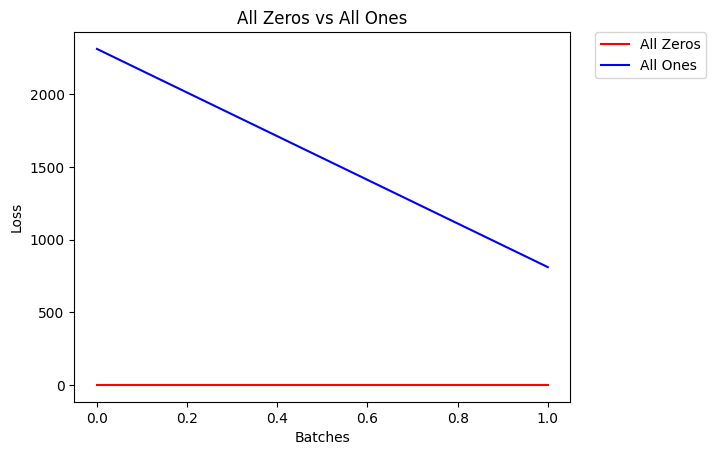

After 2 Epochs:
Validation Accuracy
    9.833% -- All Zeros
    9.975% -- All Ones
Training Loss
    2.303  -- All Zeros
  811.563  -- All Ones


In [39]:
model_list = [(model_0, 'All Zeros'),   # не надо менять название лейбла модели, на это завязаны тесты
              (model_1, 'All Ones')]    # не надо менять название лейбла модели, на это завязаны тесты

compare_init_weights(model_list,
                             'All Zeros vs All Ones',
                             train_loader,
                             valid_loader)

Как вы можете видеть, точность близка к случайному угадыванию как для нулей, так и для единиц, около 10%.

Нейронной сети трудно определить, какие веса должны быть изменены, так как нейроны имеют одинаковый выход для каждого слоя.  Чтобы избежать нейронов с одинаковым выходом, давайте использовать уникальные веса.  Мы также можем случайным образом выбрать веса, чтобы избежать застревания в локальном минимуме для каждого запуска.

Хорошим решением для получения этих случайных весов является выборка из однородного распределения.

# Воспроизводимость результатов

Для того, чтобы запуск в колабе и запуск в пайплайных были более-менее воспроизводимы, воспользуйтесь следующей функцией. См так же [заметку](https://pytorch.org/docs/stable/notes/randomness.html) о воспроизводимости в доке pytorch

In [44]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    if torch.__version__ >= '1.8':
        torch.use_deterministic_algorithms(True)
    else:
        torch.set_deterministic(True)

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


### Равномерное распределение
[Равномерное распределение](https://en.wikipedia.org/wiki/Uniform_distribution) имеет равную вероятность выбора любого числа из набора. Мы будем выбирать из непрерывного распределения, поэтому вероятность выбора одного и того же числа невелика.

### Uniform Initialization, Baseline


Давайте посмотрим, насколько хорошо нейронная сеть тренируется с использованием равномерной инициализации весов, где параметры равномерного распределения `a=0.0` и `b=1.0`. Мы рассмотрим другой способ инициализации весов нейросети (помимо использованного в коде класса Net). Чтобы инициализировать веса вне определения модели, вы можете:
1. Определить функцию, которая инициализирует веса нужных слоев (в нашем случае - линейных)

2. Инициализировать модель, используя `model.apply(fn)`, которая применяет функцию `fn` к каждому слою модели.

Для равномерной инициализации весов нашей модели используйте `weight.data.uniform_`.

**Задание:** допишите функцию равномерной инициализации весов

In [55]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
      m.weight.data.uniform_(0.0, 1.0)
      if m.bias is not None:
        m.bias.data.uniform_(0.0, 1.0)

In [56]:
# create a new model with these weights
model_uniform = Net()

seed_everything(42)
model_uniform.apply(weights_init_uniform)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 1, Training Loss: 24924.8471
Epoch 2, Training Loss: 2448.4716


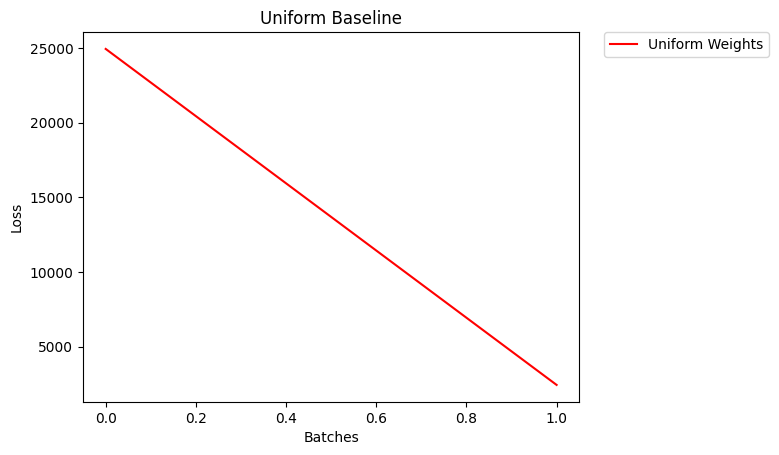

After 2 Epochs:
Validation Accuracy
   55.167% -- Uniform Weights
Training Loss
  2448.472  -- Uniform Weights


In [57]:
# evaluate behavior
compare_init_weights([(model_uniform, 'Uniform Weights')],  # не надо менять название лейбла модели, на это завязаны тесты
                             'Uniform Baseline',
                             train_loader,
                             valid_loader)

---
График потерь показывает, что нейронная сеть учится, чего она не делала со всеми нулями или со всеми единицами. Мы движемся в правильном направлении!

## Общее правило инициализации весов
Общее правило для инициализации весов в нейронной сети состоит в том, чтобы установить их близкими к нулю, но не слишком маленькими.
>Хорошая практика заключается в том, чтобы инициализировать веса в диапазоне $[- y, y]$, где $y=1/\sqrt{n}$  
($n$ - это число входов в данный нейрон).

Давайте посмотрим, верно ли это: центрируем наш равномерный диапазон относительно нуля, сдвинув его на 0,5.  Это даст нам диапазон [-0.5, 0.5] равномерного распределения.

**Задание:** поменяйте функцию равномерной инициализации весов, чтобы распределение весов было в диапозоне [-0.5, 0.5].

In [58]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_center(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
      m.weight.data.uniform_(-0.5, 0.5)
      if m.bias is not None:
        m.bias.data.uniform_(-0.5, 0.5)

# create a new model with these weights
model_centered = Net()

seed_everything(42)
model_centered.apply(weights_init_uniform_center)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [60]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = 1 / np.sqrt(m.in_features)
        m.weight.data.uniform_(-y, y)
        if m.bias is not None:
            m.bias.data.uniform_(-y, y)

# create a new model with these weights
model_rule = Net()
model_rule.apply(weights_init_uniform_rule)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 1, Training Loss: 3.0778
Epoch 2, Training Loss: 0.8186
Epoch 1, Training Loss: 0.6344
Epoch 2, Training Loss: 0.4176


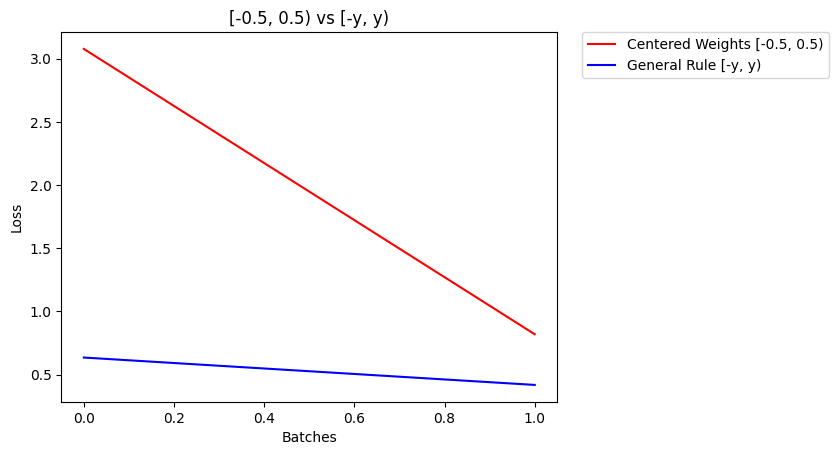

After 2 Epochs:
Validation Accuracy
   80.100% -- Centered Weights [-0.5, 0.5)
   85.233% -- General Rule [-y, y)
Training Loss
    0.819  -- Centered Weights [-0.5, 0.5)
    0.418  -- General Rule [-y, y)


In [61]:
model_list = [(model_centered, 'Centered Weights [-0.5, 0.5)'),  # не надо менять название лейбла модели, на это завязаны тесты
              (model_rule, 'General Rule [-y, y)')]              # не надо менять название лейбла модели, на это завязаны тесты

compare_init_weights(model_list,
                             '[-0.5, 0.5) vs [-y, y)',
                             train_loader,
                             valid_loader)

Такое поведение действительно многообещающе! Мало того, что лосс уменьшается, но, кажется, это происходит очень быстро; всего через две эпохи мы получаем довольно высокую точность на тесте. Это должно дать вам некоторое представление о том, почему хорошая инициализация весов действительно может помочь тренировочному процессу!

---

Равномерное распределение имеет одинаковый шанс выбрать *любое значение* в диапазоне. Что, если мы используем распределение, которое имеет более высокий шанс выбрать числа ближе к 0?  Давайте рассмотрим на нормальное распределение.

### Hормальное распределение
В отличие от равномерного распределения, [нормальное распределение](https://en.wikipedia.org/wiki/Normal_distribution) имеет более высокую вероятность выбора числа, близкого к среднему значению.

**Задание:** добавьте нормальное распределение:
как стандартное отклонение выберите $y=1/\sqrt{n}$

In [52]:
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''

    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n = m.in_features
        stddev = 1.0 / (n ** 0.5)
        m.weight.data.normal_(0, stddev)
        if m.bias is not None:
            m.bias.data.zero_()

In [53]:
## -- no need to change code below this line -- ##

# create a new model with the rule-based, uniform weights
model_uniform_rule = Net()

seed_everything(42)
model_uniform_rule.apply(weights_init_uniform_rule)

# create a new model with the rule-based, NORMAL weights
model_normal_rule = Net()

seed_everything(42)
model_normal_rule.apply(weights_init_normal)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 1, Training Loss: 3.1478
Epoch 2, Training Loss: 0.8372
Epoch 1, Training Loss: 0.5937
Epoch 2, Training Loss: 0.4167


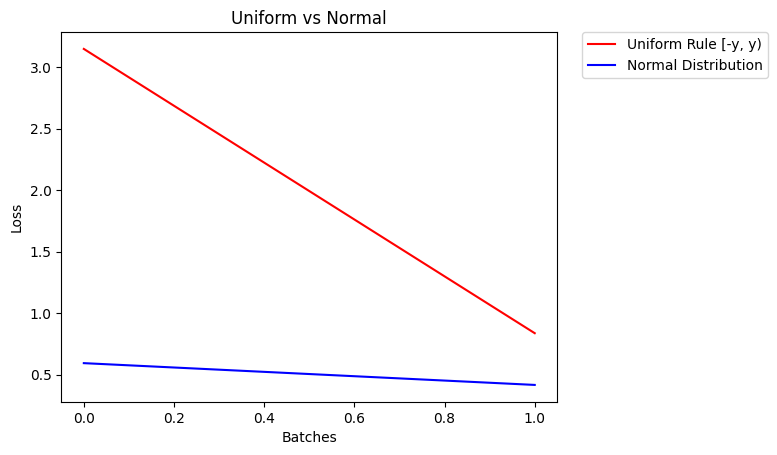

After 2 Epochs:
Validation Accuracy
   79.975% -- Uniform Rule [-y, y)
   86.142% -- Normal Distribution
Training Loss
    0.837  -- Uniform Rule [-y, y)
    0.417  -- Normal Distribution


In [54]:
model_list = [(model_uniform_rule, 'Uniform Rule [-y, y)'), # не надо менять название лейбла модели, на это завязаны тесты
              (model_normal_rule, 'Normal Distribution')]   # не надо менять название лейбла модели, на это завязаны тесты

compare_init_weights(model_list,
                             'Uniform vs Normal',
                             train_loader,
                             valid_loader)

Нормальное распределение дает нам довольно похожее поведение по сравнению с равномерным распределением в данном случае. Вероятно, это связано с тем, что наша сеть очень мала; более крупная нейронная сеть будет выбирать больше весовых значений из каждого из этих распределений, увеличивая эффект обоих стилей инициализации. В общем случае нормальное распределение приведет к улучшению качества модели.